In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
/kaggle/input/style-transfer-images/content-images/lion.jpg
/kaggle/input/style-transfer-images/content-images/taj_mahal.jpg
/kaggle/input/style-transfer-images/content-images/green_bridge.jpg
/kaggle/input/style-transfer-images/content-images/golden_gate2.jpg
/kaggle/input/style-transfer-images/content-images/golden_gate.jpg
/kaggle/input/style-transfer-images/content-images/figures.jpg
/kaggle/input/style-transfer-images/content-images/tubingen.png
/kaggle/input/style-transfer-images/style-images/vg_la_cafe.jpg
/kaggle/input/style-transfer-images/style-images/vg_starry_night.jpg
/kaggle/input/style-transfer-images/style-images/vg_houses.jpg
/kaggle/input/style-transfer-images/style-images/giger_crop.jpg
/kaggle/input/style-transfer-images/style-images/vg_wheat_field_cropped.jpg
/kaggle/input/style-transfer-images/style-images/vg_sta

In [51]:
#imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import namedtuple
import matplotlib.pyplot as plt

In [52]:
#utils
imsize = 256

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

unloader = transforms.Compose([
    transforms.Normalize(mean=[-2.118, -2.036, -1.804],
                         std=[4.367, 4.464, 4.444]),
    transforms.ToPILImage()
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    return loader(image).unsqueeze(0).to(device)

def show_image(tensor, title=''):
    img = tensor.clone().cpu().squeeze(0)
    img = unloader(img)
    plt.imshow(img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

def show_images(images, titles=None):
    num_images = len(images)
    plt.figure(figsize=(5 * num_images, 5))

    for i, image_t in enumerate(images):
        img = image_t.clone().cpu().squeeze(0)  
        img = unloader(img)  

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i], fontsize=14)

    plt.tight_layout()
    plt.show()

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
# vgg19 architecture
class Vgg19(nn.Module):
    def __init__(self, requires_grad=False, show_progress=False, use_relu=True):
        super().__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True, progress=show_progress).features
        if use_relu: 
            self.layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'conv4_2', 'relu5_1']
            self.offset = 1
        else:
            self.layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']
            self.offset = 0

        self.content_feature_maps_index = 4  # conv4_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))
        self.style_feature_maps_indices.remove(4)

        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()
        self.slice6 = nn.Sequential()
        for x in range(1+self.offset):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(1+self.offset, 6+self.offset):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(6+self.offset, 11+self.offset):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(11+self.offset, 20+self.offset):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(20+self.offset, 22):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        for x in range(22, 29+self.offset):  
            self.slice6.add_module(str(x), vgg_pretrained_features[x])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        layer1_1 = x
        x = self.slice2(x)
        layer2_1 = x
        x = self.slice3(x)
        layer3_1 = x
        x = self.slice4(x)
        layer4_1 = x
        x = self.slice5(x)
        conv4_2 = x
        x = self.slice6(x)
        layer5_1 = x
        vgg_outputs = namedtuple("vgg_outs", self.layer_names)
        out = vgg_outputs(layer1_1, layer2_1, layer3_1, layer4_1, conv4_2, layer5_1)
        return out


In [55]:
def run_style_transfer(content_img, style_img, num_steps=300, style_weight=1e6, content_weight=1, tv_weight=1e-6):
    vgg = Vgg19().to(device).eval()
    target_features = vgg(content_img)
    style_features = vgg(style_img)

    content_target = target_features[4].detach()
    style_targets = [gram_matrix(style_features[i]).detach() for i in vgg.style_feature_maps_indices]

    input_img = content_img.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([input_img], lr=0.01)

    mse = nn.MSELoss()
    run = [0]

    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            gen_features = vgg(input_img)
            content_loss = mse(gen_features[4], content_target)
            
            style_loss = 0
            for i, idx in enumerate(vgg.style_feature_maps_indices):
                G = gram_matrix(gen_features[idx])
                A = style_targets[i]
                style_loss += mse(G, A)

            tv_loss = total_variation(input_img)
            

            total_loss = content_weight*content_loss + style_weight*style_loss + tv_weight * tv_loss
            total_loss.backward()
            run[0] += 1
            return total_loss
        with torch.no_grad():
            input_img.clamp_(-1.5, 1.5)
        
        optimizer.step(closure)

    return input_img.detach()


In [56]:
content = load_image('/kaggle/input/style-transfer-images/content-images/lion.jpg')
style = load_image('/kaggle/input/style-transfer-images/style-images/candy.jpg')
output = run_style_transfer(content, style, num_steps=300, style_weight=1e9, content_weight=1, tv_weight=1e-3)

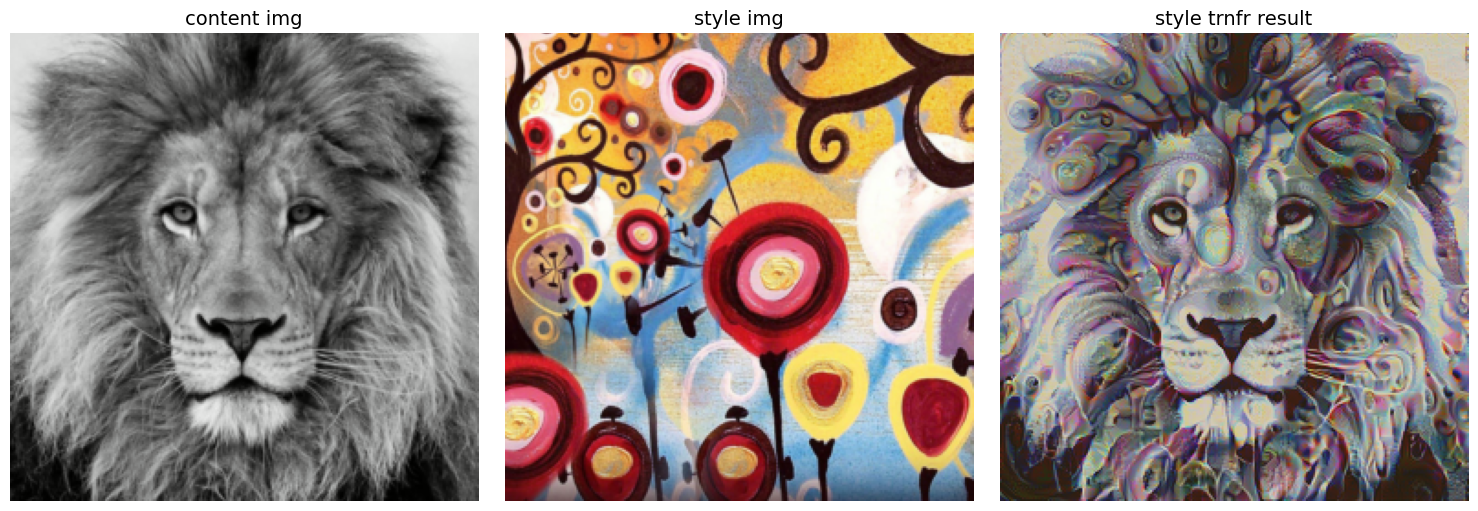

In [57]:
show_images([content, style, output], ["content img", "style img", "style trnfr result"])

 > ### **"The lion, trained in the arcane arts of convolutional sorcery, delicately extracts the stylistic essence of a Van Gogh painting and whispers it onto the fur of a JPEG dog, never once disturbing its sacred content pixels."**
